In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
import pandas as pd
import pytorch3d

In [2]:
force_cpu = True
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)


Using device cpu


In [3]:
class JointDataset(Dataset): 
    def __init__(self, x, joint_names):
        self.x = x
        self.joint_names = joint_names
        super().__init__()
    def __len__(self):
        return self.x.size(0)
    def __getitem__(self, idx):
        return self.x[idx]


def make_joint_dataset(device: torch.device):
    
    with open("data/unlabelled/camera/joints/front_sit_stand.csv") as f:
        data = pd.read_csv(f, header=0)
        data = data.rename(columns={"x-axis": "x", "y-axis": "y", "z-axis": "z", "joint_names": "joint_name"})
        print(data.head())
    
    # Get the unique joint names and frame IDs
    joint_names = data["joint_name"].unique()
    frame_ids = data["frame_id"].unique()
    
    # Create a multi-index using 'frame_id' and 'joint_names'
    data.set_index(['frame_id', 'joint_name'], inplace=True)
    
    # Sort the index to ensure the data is in the correct order
    data.sort_index(inplace=True)
    
    # Convert the DataFrame to a NumPy array and reshape it
    x = data[['x', 'y', 'z']].values.reshape((frame_ids.size, joint_names.size, 3))
        
    dataset = JointDataset(
        joint_names=np.sort(joint_names),
        x=torch.from_numpy(x.reshape(x.shape[0], -1)).float().to(device))
    return dataset

In [4]:
# Load the data
train_dataset = make_joint_dataset(device=device)

   frame_id  timestamp_usec     joint_name          x           y            z
0         0          268566         PELVIS -35.965904  121.446609  2231.891113
1         0          268566    SPINE_NAVEL -46.754833  -36.169590  2264.973877
2         0          268566    SPINE_CHEST -54.007175 -164.899796  2259.733398
3         0          268566           NECK -55.790428 -348.966309  2191.183594
4         0          268566  CLAVICLE_LEFT -25.078732 -319.862854  2204.463135


In [5]:
train_dataset.x[0].reshape(32, 3).cpu().numpy()

array([[ 142.20766  ,  522.14825  , 2098.596    ],
       [-160.67505  ,  542.2831   , 2075.3567   ],
       [ -25.078732 , -319.86285  , 2204.4631   ],
       [ -85.8965   , -317.9064   , 2202.3394   ],
       [  18.672644 , -468.6959   , 2136.2637   ],
       [-127.32989  , -453.0575   , 2105.0806   ],
       [ 146.30359  ,  -33.99539  , 2165.623    ],
       [-203.42929  ,  -23.675352 , 2150.4087   ],
       [  -7.2281733, -423.77747  , 2033.9568   ],
       [ -52.0062   , -413.8788   , 2022.3567   ],
       [ 164.7248   ,  686.3532   , 2063.1277   ],
       [-212.06987  ,  682.9324   , 2031.8286   ],
       [  65.83153  ,  200.97363  , 1876.0988   ],
       [ -77.20744  ,  190.38484  , 1876.1362   ],
       [ 120.02299  ,  139.68652  , 1929.6199   ],
       [ -60.212757 ,  120.30266  , 1939.6466   ],
       [ -55.919403 , -413.0576   , 2154.382    ],
       [  46.294876 ,  116.650375 , 2235.8672   ],
       [-110.14407  ,  125.77158  , 2228.3057   ],
       [ 100.85912  ,  241.478 

In [6]:
list(train_dataset.joint_names).index('PELVIS')

23

In [7]:
train_dataset.x[0].reshape(-1, 3).cpu().numpy()[23, :]

array([ -35.965904,  121.44661 , 2231.891   ], dtype=float32)

In [8]:
class VAE(nn.Module):

    def __init__(self, input_dim, z_dim):
        super().__init__()
        # Encoder ---------------------
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, 2**5),
            nn.ReLU())
        self.mu = nn.Linear(2**5, z_dim)
        self.logvar = nn.Linear(2**5, z_dim)
        # Decoder ---------------------        
        self.dec = nn.Sequential(
            nn.Linear(z_dim, 2**5),
            nn.ReLU(),
            nn.Linear(2**5, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, input_dim))

    def encode(self, x):
        x = self.enc(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.dec(z)
        x = torch.sigmoid(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
# Try the model out
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
ae = VAE(input_dim=train_dataset.x[0].size(0), z_dim=4).to(device)
for batch_idx, x, in enumerate(train_loader):
    mu = ae.mu(ae.enc(x))
    x_rec = ae.decode(mu)
    break

In [10]:
seed = 123
lr = 0.001
batch_size=64
n_epoch = 300
weight_reg_loss = 10e3
z_dim = 4
w_l_reg = 0.01

torch.manual_seed(seed)

vae = VAE(input_dim=train_dataset.x[0].size(0), z_dim=z_dim).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

optimizer_vae = optim.Adam(vae.parameters(), lr=lr)

hist_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        vae_loss, reg_loss = 0, 0
                    
        for batch_idx, x, in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            
            l_rec = F.mse_loss(recon_x, x)
            l_reg = - torch.mean(0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
            loss = l_rec + w_l_reg * l_reg
            
            loss.backward()
            optimizer_vae.step()

        # if epoch > 0 and epoch % 50 == 0:
        hist_loss.append(loss.item())
        pbar.update()
        pbar.set_postfix(loss=f"{vae_loss:.8f}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
def plot_skeleton_3d(joint_pos, joint_names):
    bone_list = [['SPINE_CHEST', 'SPINE_NAVEL'],
     ['SPINE_NAVEL', 'PELVIS'],
     ['SPINE_CHEST', 'NECK'],
     ['NECK', 'HEAD'],
     ['HEAD', 'NOSE'],
     ['SPINE_CHEST', 'CLAVICLE_LEFT'],
     ['CLAVICLE_LEFT', 'SHOULDER_LEFT'],
     ['SHOULDER_LEFT', 'ELBOW_LEFT'],
     ['ELBOW_LEFT', 'WRIST_LEFT'],
     ['WRIST_LEFT', 'HAND_LEFT'],
     ['HAND_LEFT', 'HANDTIP_LEFT'],
     ['WRIST_LEFT', 'THUMB_LEFT'],
     ['PELVIS', 'HIP_LEFT'],
     ['HIP_LEFT', 'KNEE_LEFT'],
     ['KNEE_LEFT', 'ANKLE_LEFT'],
     ['ANKLE_LEFT', 'FOOT_LEFT'],
     ['NOSE', 'EYE_LEFT'],
     ['EYE_LEFT', 'EAR_LEFT'],
     ['SPINE_CHEST', 'CLAVICLE_RIGHT'],
     ['CLAVICLE_RIGHT', 'SHOULDER_RIGHT'],
     ['SHOULDER_RIGHT', 'ELBOW_RIGHT'],
     ['ELBOW_RIGHT', 'WRIST_RIGHT'],
     ['WRIST_RIGHT', 'HAND_RIGHT'],
     ['HAND_RIGHT', 'HANDTIP_RIGHT'],
     ['WRIST_RIGHT', 'THUMB_RIGHT'],
     ['PELVIS', 'HIP_RIGHT'],
     ['HIP_RIGHT', 'KNEE_RIGHT'],
     ['KNEE_RIGHT', 'ANKLE_RIGHT'],
     ['ANKLE_RIGHT', 'FOOT_RIGHT'],
     ['NOSE', 'EYE_RIGHT'],
     ['EYE_RIGHT', 'EAR_RIGHT']]
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    
    # Determine which coordinate goes to which axis in the figure
    x, z, y = range(3) 
    
    # Invert the z axis
    ax.invert_zaxis()
    
    joint_names = list(joint_names)

    for bone in bone_list:
        idx_joint_0 = joint_names.index(bone[0])
        idx_joint_1 = joint_names.index(bone[1])
        ax.plot([joint_pos[idx_joint_0][x], joint_pos[idx_joint_1][x]],
                [joint_pos[idx_joint_0][y], joint_pos[idx_joint_1][y]],
                [joint_pos[idx_joint_0][z], joint_pos[idx_joint_1][z]], color='b')

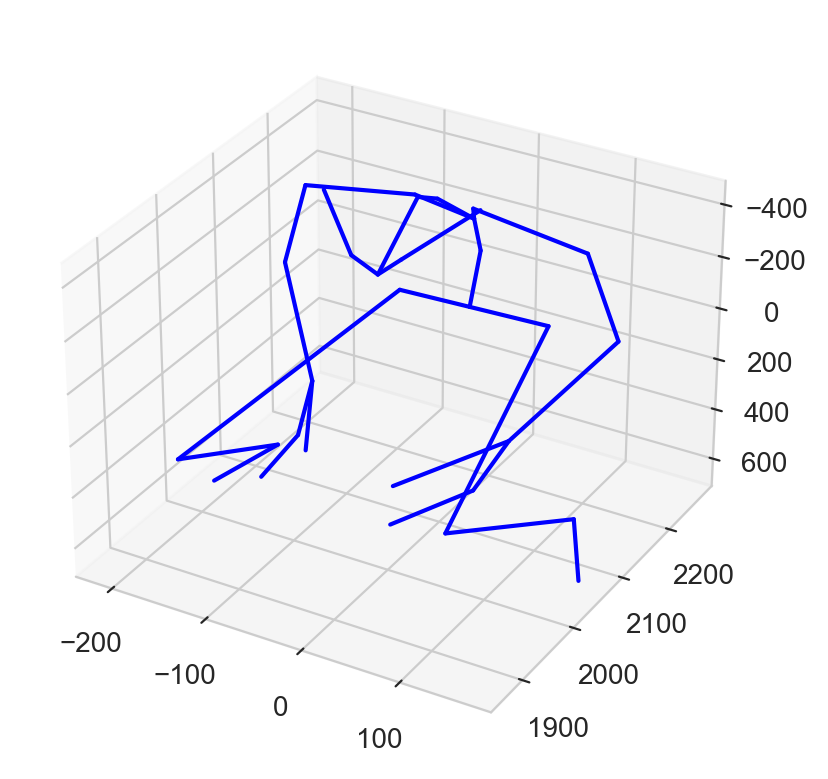

In [12]:
plot_skeleton_3d(train_dataset.x[2].reshape(32, 3).cpu().numpy(), train_dataset.joint_names)

In [13]:
ux = torch.tensor(np.array([[255,1,255],[101,10,123]])).float()

In [14]:
magnitude = ux.norm(p=2, dim=1, keepdim=True)    # NEW

In [15]:
magnitude

tensor([[360.6259],
        [159.4679]])

In [16]:
ux = F.normalize(ux, p=2, dim=1)

ux_orig = ux * magnitude                         # NEW

print(ux_orig)

tensor([[255.,   1., 255.],
        [101.,  10., 123.]])


In [17]:
x = train_dataset.x

In [18]:
pelvis_idx = list(train_dataset.joint_names).index("PELVIS")

In [19]:
def compute_quaternion(A, B): 
    
    # Normalize A and B to get unit vectors.
    A_normalized = A / torch.norm(A)
    B_normalized = B / torch.norm(B)
    
    # Compute the rotation axis, which is the cross product of A and B.
    v = torch.cross(A_normalized, B_normalized)
    
    # Compute the scalar part of the quaternion.
    w = torch.sqrt((torch.norm(A) ** 2) * (torch.norm(B) ** 2)) + torch.dot(A_normalized, B_normalized)
    
    # Compute the quaternion.
    quaternion = torch.cat([w.unsqueeze(0), v])
    
    quaternion = quaternion / torch.norm(quaternion)
    return quaternion

def quaternion_mult(q1, q2):
    w1, x1, y1, z1 = q1[0], q1[1], q1[2], q1[3]
    w2, x2, y2, z2 = q2[0], q2[1], q2[2], q2[3]
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return torch.tensor([w, x, y, z])

def rotate(point, quaternion):
    # Extend the point to a 4D vector by adding a zero as the scalar part.
    point_extended = torch.cat([torch.zeros(1), point])

    # Compute the conjugate of the quaternion.
    quaternion_conjugate = torch.cat([quaternion[0:1], -quaternion[1:]], dim=-1)

    # Rotate the point using the quaternion.
    point_rotated = quaternion_mult(quaternion_mult(quaternion, point_extended), quaternion_conjugate)

    # The rotated point is the vector part of the result.
    pt = point_rotated[1:]
    return pt

# Assuming A and B are 3D tensors representing the coordinates in 3D space.
A = torch.tensor([1.0, 0.0, 0.0])
B = torch.tensor([0.0, 1.0, 0.0])
quaternion = compute_quaternion(A, B)
rec_B = rotate(A, quaternion)
print(rec_B)

tensor([0.0000, 1.0000, 0.0000])


In [20]:
rec_B

tensor([0.0000, 1.0000, 0.0000])

In [51]:
import torch
from pytorch3d.transforms import quaternion_invert, quaternion_apply, axis_angle_to_quaternion, so3_exponential_map

# Let's assume A and B are 3D points
A = torch.tensor([1.0, 5.0, 3.0])
B = torch.tensor([4.0, 3.0, 6.0])

print("A", A)
print("B", B)

# Compute the vector from A to B
vector = B - A

# Normalize the vector to get the axis of rotation
axis_of_rotation = vector / torch.norm(vector)

# The angle of rotation is the arccosine of the dot product of the normalized vectors
angle_of_rotation = torch.acos(torch.dot(A / torch.norm(A), B / torch.norm(B)))

# The axis-angle representation is the axis of rotation scaled by the angle of rotation
axis_angle = axis_of_rotation * angle_of_rotation

# Convert the axis-angle representation to a quaternion
rotation = axis_angle_to_quaternion(axis_angle)

# Apply the rotation to point A
A_rotated = quaternion_apply(rotation, A)

# Compute the translation vector
translation = B - A_rotated

# Apply the translation to point A
A_transformed = A_rotated + translation

print("A transformed into B:", A_transformed)

# Compute the inverse rotation and translation
inverse_rotation = quaternion_invert(rotation)
inverse_translation = -translation

# Apply the inverse transformation: from B, recover A
B_transformed = B.clone()
B_transformed += inverse_translation # Apply inverse translation
B_transformed = quaternion_apply(inverse_rotation, B_transformed)  # Apply inverse rotation

print("B transformed into A:", B_transformed)

A tensor([1., 5., 3.])
B tensor([4., 3., 6.])
A transformed into B: tensor([4., 3., 6.])
B transformed into A: tensor([1.0000, 5.0000, 3.0000])


In [56]:
# Let's assume A and B are 3D points
A = torch.tensor([1.0, 5.0, 3.0])
B = torch.tensor([4.0, 3.0, 6.0])

print("A", A)
print("B", B)

normalized_A, normalized_B = A / torch.norm(A), B / torch.norm(B)

# Calculate the axis of rotation
axis = torch.cross(normalized_A, normalized_B)
axis = axis / torch.norm(axis)

# Alternative way to get the axis of rotation?
# vector = B - A
# axis_of_rotation = vector / torch.norm(vector)

# The angle of rotation is the arccosine of the dot product of the normalized vectors
angle_of_rotation = torch.acos(torch.dot(normalized_A, normalized_B))

# The axis-angle representation is the axis of rotation scaled by the angle of rotation
axis_angle = axis_of_rotation * angle_of_rotation

# Convert the axis-angle representation to a quaternion
rotation = axis_angle_to_quaternion(axis_angle)

# Apply the rotation to point A
A_rotated = quaternion_apply(rotation, A)

# Compute the translation vector
translation = B - A_rotated

# Apply the translation to point A
A_transformed = A_rotated + translation

print("A transformed into B:", A_transformed)

# Compute the inverse rotation and translation
inverse_rotation = quaternion_invert(rotation)
inverse_translation = -translation

# Apply the inverse transformation: from B, recover A
B_transformed = B.clone()
B_transformed += inverse_translation # Apply inverse translation
B_transformed = quaternion_apply(inverse_rotation, B_transformed)  # Apply inverse rotation

print("B transformed into A:", B_transformed)

A tensor([1., 5., 3.])
B tensor([4., 3., 6.])
A transformed into B: tensor([4., 3., 6.])
B transformed into A: tensor([1.0000, 5.0000, 3.0000])


In [62]:
# Center the points and reduce to unit-sphere

points = train_dataset.x.reshape(-1, 3) #.cpu().numpy()

centroid = torch.mean(points, axis=0)
points -= centroid
furthest_distance = torch.max(torch.sqrt(torch.sum(points**2,axis=-1)))
points /= furthest_distance

points = points.reshape(-1, 32, 3)
